In [1]:
import pyreadr
import numpy as onp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import jax.numpy as jnp
from scipy.stats import linregress

import sys
import os
# sys.path.append("../../../models") # lab server
sys.path.append("../../../contrastive-regression/models/") # lab server
# from linear_cr import LinearCR
from linear_cr_new import LinearContrastiveRegression

In [2]:
def return_indices_of_a(a, b):
  b_set = set(b)
  return [i for i, v in enumerate(a) if v in b_set]

In [3]:
ct = 'L2or3'
df = pyreadr.read_r('../pb/'+ ct + '.rds')[None]
hvg = pyreadr.read_r('../hvg1k/'+ ct +'.rds')[None]
input1 = df.index.values.tolist()
input2 = hvg[None].to_list()
match_id = return_indices_of_a(input1,input2)
# print(len(match_id))
df = df.iloc[match_id]
print(df.shape)

(1000, 41)


In [4]:
score_type = 'scoreA'
output_dir = './' + score_type + '/'
if not os.path.exists(output_dir):
   os.makedirs(output_dir)

score = pyreadr.read_r('../'+ score_type + '_pfc.rds')[None]
print(score.shape)

(20, 5)


In [5]:
X = df[score['sample'][score['diagnosis']=='ASD'].to_list()].to_numpy().T
print(type(X))
print(X.shape)

<class 'numpy.ndarray'>
(10, 1000)


In [6]:
# A = df[score['sample'][score['diagnosis']=='ASD'].to_list()]
# print(list(A) == score['sample'][score['diagnosis']=='ASD'].to_list())
Y = df[score['sample'][score['diagnosis']=='Control'].to_list()].to_numpy().T
print(type(Y))
print(Y.shape)

<class 'numpy.ndarray'>
(10, 1000)


In [7]:
R = score['zscore'][score['diagnosis']=='ASD']
R = onp.atleast_2d(R).T
#print(R)

In [8]:
# Instantiate model
model = LinearContrastiveRegression()

# Fit model
d = 8 # dimension reduction
model.fit(X, Y, R, d, seed = 50)

# Make predictions on training data
preds = model.predict(X)

Step: 0               Log marginal lik.: -2903.68
Step: 200             Log marginal lik.: 19581.49
Step: 400             Log marginal lik.: 39306.37
Step: 600             Log marginal lik.: 57798.46
Step: 800             Log marginal lik.: 70476.08


In [9]:
_, _, r2_contrastivereg, _, _ = linregress(R.squeeze(), preds)
print(r2_contrastivereg)

0.8846726571922839


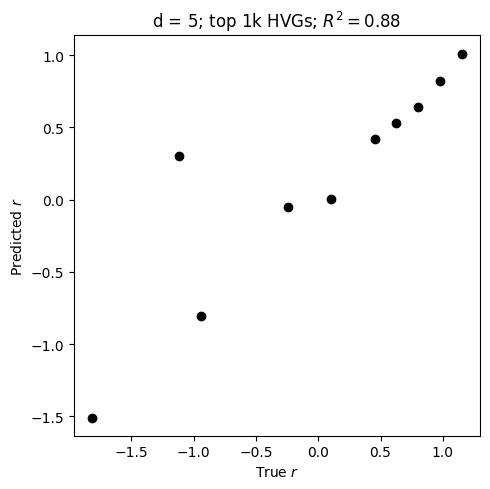

In [10]:
plt.figure(figsize=(5, 5))
plt.subplot()
plt.scatter(R, preds, c="black")
plt.xlabel(r"True $r$")
plt.ylabel(r"Predicted $r$")
plt.title(r"d = 5; top 1k HVGs; $R^2 = " + str(round(r2_contrastivereg, 2)) + "$")

plt.tight_layout()
plt.show()

In [11]:
# check latent factor t
latent_t = onp.asarray(model.t)
asd_sample = score['sample'][score['diagnosis']=='ASD'].to_list()
dims = ["Dim%d" % i for i in range(1,9)]

In [12]:
loading_w = pd.DataFrame(model.W, columns = df.index.to_list(), index = dims,dtype = "float")
pyreadr.write_rds(output_dir + 'seed50_W.rds', loading_w, compress="gzip")
print(loading_w.head())

      RP5-857K21.4  MTND1P23  MTND2P28  RP5-857K21.6  MTATP6P1     ACAP3  \
Dim1      0.007396  0.001292  0.050846      0.002466  0.029914  0.045361   
Dim2     -0.007466  0.061121  0.007521      0.037499  0.215214  0.029721   
Dim3     -0.010773  0.008954  0.068028      0.026719 -0.185318 -0.016017   
Dim4      0.006451  0.027898 -0.032830      0.064432 -0.139675 -0.072727   
Dim5      0.081590  0.074337  0.023578      0.126087  0.265312  0.102958   

         GABRD      CHD5      ENO1    CLSTN1  ...  MAPK8IP2   TEKT4P2  \
Dim1  0.045174  0.062629  0.033882  0.168574  ...  0.019719 -0.012837   
Dim2  0.087392  0.044979  0.092027  0.218494  ...  0.075403 -0.018914   
Dim3 -0.029554 -0.059524 -0.030802 -0.088372  ... -0.017968 -0.074536   
Dim4 -0.068749 -0.116623 -0.075207 -0.204780  ... -0.042033 -0.020701   
Dim5  0.088931  0.207110  0.006364  0.273463  ...  0.057527  0.003166   

      bP-21201H5.1  ANKRD20A11P  MIR99AHG     ATP5J       APP      SOD1  \
Dim1      0.081148     0.0135

In [13]:
latent_t = pd.DataFrame(model.t, columns = dims, index = asd_sample, dtype="float")
pyreadr.write_rds(output_dir + 'seed50_t.rds', latent_t, compress="gzip")
print(latent_t.head())

              Dim1      Dim2      Dim3      Dim4      Dim5      Dim6  \
5144_PFC  1.575913  0.138727 -0.608633  0.376823 -0.512849 -0.069165   
5278_PFC -0.246964 -0.021693 -0.166993 -0.134065 -0.539107 -0.253600   
5294_BA9  0.255465 -0.304961 -0.198937  0.051205 -0.095669  0.047448   
5403_PFC  0.473435  0.914429 -0.209951  0.635984 -0.003894 -1.367561   
5419_PFC  0.335515 -0.039284  0.108743 -0.652836 -0.517059 -0.706653   

              Dim7      Dim8  
5144_PFC -0.677472  0.018107  
5278_PFC -0.411744 -0.550633  
5294_BA9  0.023040  0.200309  
5403_PFC -0.110785 -0.140903  
5419_PFC -0.874684  0.324621  


In [14]:
pyreadr.write_rds(output_dir + 'seed50_beta.rds', pd.DataFrame(data=model.beta), compress="gzip")

In [15]:
auxiliary_s = pd.DataFrame(model.S, columns = df.index.to_list(), index = dims, dtype="float")
print(auxiliary_s.head)
pyreadr.write_rds(output_dir + 'seed50_S.rds', auxiliary_s, compress="gzip")

<bound method NDFrame.head of       RP5-857K21.4  MTND1P23  MTND2P28  RP5-857K21.6  MTATP6P1     ACAP3  \
Dim1      0.043422 -0.140669  0.003390     -0.218189  0.163263  0.041045   
Dim2     -0.010303  0.053918 -0.000594      0.060431 -0.046206 -0.009994   
Dim3      0.073436 -0.046309  0.003751     -0.040838  0.172857  0.131038   
Dim4     -0.043180  0.054936 -0.006413      0.096399 -0.110498 -0.081423   
Dim5      0.044514 -0.137942  0.003870     -0.178676  0.152599  0.058960   
Dim6     -0.044827  0.022002 -0.007029      0.029020 -0.125696 -0.051064   
Dim7     -0.018703 -0.003135 -0.001593      0.016910 -0.090978 -0.062427   
Dim8      0.018801  0.130474  0.001525      0.192764  0.095607  0.013586   

         GABRD      CHD5      ENO1    CLSTN1  ...  MAPK8IP2   TEKT4P2  \
Dim1 -0.026067  0.030140 -0.014681 -0.139587  ...  0.003881  0.021900   
Dim2  0.029971 -0.002332  0.033409  0.101058  ...  0.008594  0.035033   
Dim3  0.050590  0.173965  0.016655  0.129257  ...  0.031209  0.005

In [16]:
## sort by absolute value of beta
beta = onp.array(model.beta.T.flatten())
print(beta)
indices = onp.argsort(abs(beta))
max_abs_beta_index = indices[-1] # start from 0
target_dim = 'Dim' + str(max_abs_beta_index + 1)
print('Dimension with largest absolute value of beta: ' + target_dim)

[ 0.17734481  0.25968614 -1.0707816  -0.11132038 -0.50167763 -0.5032521
  0.86582905  0.4252514 ]
Dimension with largest absolute value of beta: Dim3


In [17]:
## sort gene (w)
w_d = loading_w.loc[[target_dim]].T
w_d['gene'] = w_d.index.values.tolist()
sorted_w_d = w_d.sort_values(by=target_dim, ascending=False)
sorted_w_d['rank'] = list(range(1,w_d.shape[0]+1))
sorted_w_d.to_csv(output_dir + 'seed50_gene_rank_max_abs_beta.csv', index = False)

sorted_w_d

,Dim3,gene,rank
ARL17B,0.119284,ARL17B,1
CTB-57H20.1,0.098815,CTB-57H20.1,2
RP11-864N7.2,0.092260,RP11-864N7.2,3
RP13-258O15.1,0.089394,RP13-258O15.1,4
P2RY14,0.075072,P2RY14,5
...,...,...,...
CADM2,-0.811763,CADM2,996
NRXN3,-0.829774,NRXN3,997
PTPRD,-0.929255,PTPRD,998
CNTNAP2,-0.938109,CNTNAP2,999
